# Goldfeld's conjecture for congruent number curves

The notebook contains code to understand the distribution of analytic ranks of congruent number curves. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("an_rk.csv")

df = df.sort_values("n")  # sort by n for running analysis

# Preview structure
df[['n', 'an_rk_magma']].head()

,n,an_rk_magma
0,1,0
1,2,0
2,3,0
3,5,1
4,6,1


In [16]:
# Get total counts
rk_counts = df['an_rk_magma'].value_counts().sort_index()
print(len(df))
print(rk_counts)

98400
an_rk_magma
0    43529
1    48917
2     5665
3      285
4        4
Name: count, dtype: int64


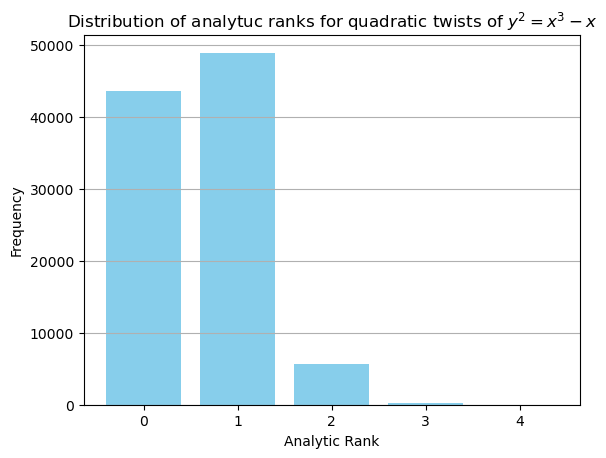

In [17]:
plt.bar(rk_counts.index, rk_counts.values, color='skyblue')
plt.xlabel('Analytic Rank')
plt.ylabel('Frequency')
plt.title('Distribution of analytuc ranks for quadratic twists of $y^2 = x^3 - x$')
plt.xticks(range(max(df['an_rk_magma']) + 1))
plt.grid(axis='y')
plt.savefig("anarankdist.jpeg")
plt.show()

**Rank Proportions vs. Upper Bound (Goldfeld)**

**Running Proportions to Study Convergence**

In [8]:
import numpy as np

# Create indicator columns
df['is_rank_0'] = (df['an_rk_magma'] == 0)
df['is_rank_ge1'] = (df['an_rk_magma'] == 1)

# Running sums
df['cum_rank_0'] = df['is_rank_0'].cumsum()
df['cum_rank_ge1'] = df['is_rank_ge1'].cumsum()
df['index'] = np.arange(1, len(df) + 1)

# Running proportions
df['prop_rank_0'] = df['cum_rank_0'] / df['index']
df['prop_rank_ge1'] = df['cum_rank_ge1'] / df['index']


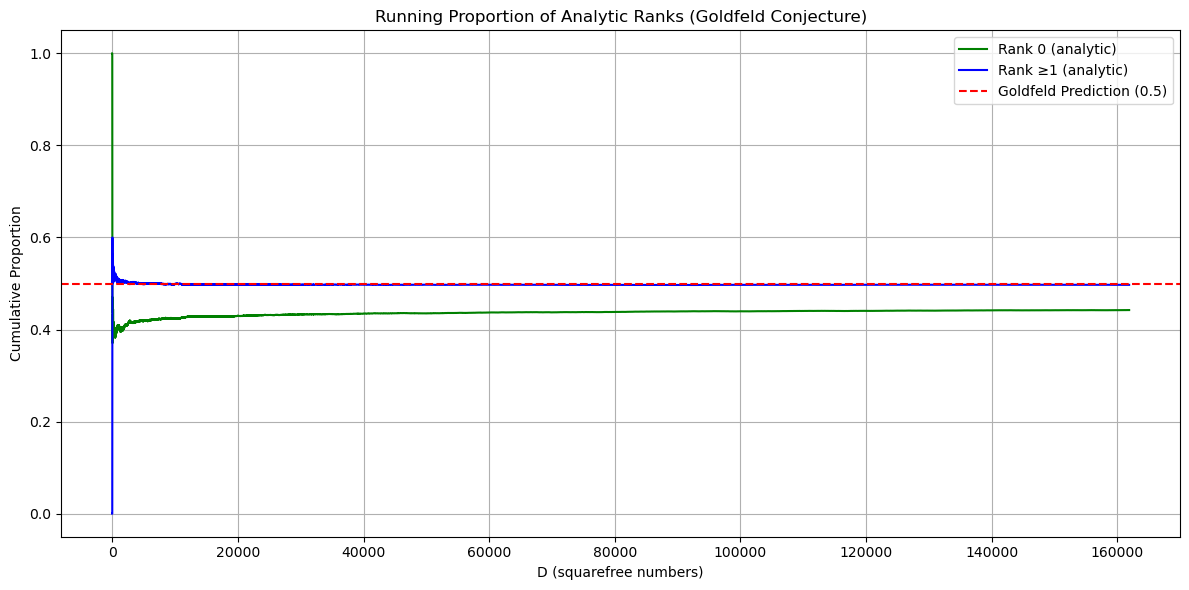

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['n'], df['prop_rank_0'], label='Rank 0 (analytic)', color='green')
plt.plot(df['n'], df['prop_rank_ge1'], label='Rank ≥1 (analytic)', color='blue')
plt.axhline(0.5, linestyle='--', color='red', label='Goldfeld Prediction (0.5)')

plt.xlabel('D (squarefree numbers)')
plt.ylabel('Cumulative Proportion')
plt.title('Running Proportion of Analytic Ranks (Goldfeld Conjecture)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("runningprop.jpeg")
plt.show()


In [11]:
from scipy.stats import chisquare

# Total counts
rank_0 = df['is_rank_0'].sum()
rank_ge1 = df['is_rank_ge1'].sum()
total = rank_0 + rank_ge1

# Expected under 50/50 split
expected = [0.5 * total, 0.5 * total]
observed = [rank_0, rank_ge1]

# Chi-squared test
chi2_stat, pval_chi2 = chisquare(f_obs=observed, f_exp=expected)

print("Chi-squared Test (vs. Goldfeld 50/50)")
print(f"  Observed: [rank 0: {rank_0}, rank ≥1: {rank_ge1}]")
print(f"  Expected: [rank 0: {expected[0]:.0f}, rank ≥1: {expected[1]:.0f}]")
print(f"  Chi² = {chi2_stat:.4f}, p-value = {pval_chi2:.6f}")


Chi-squared Test (vs. Goldfeld 50/50)
  Observed: [rank 0: 43529, rank ≥1: 48917]
  Expected: [rank 0: 46223, rank ≥1: 46223]
  Chi² = 314.0270, p-value = 0.000000


In [12]:
# Use observed proportions as expected
empirical_p0 = rank_0 / total
empirical_p1 = rank_ge1 / total
expected_emp = [empirical_p0 * total, empirical_p1 * total]

# Chi-squared (should return zero, since observed == expected)
chi2_emp, pval_emp = chisquare(f_obs=observed, f_exp=expected_emp)

print("Chi-squared Test (vs. Empirical Distribution)")
print(f"  Empirical proportions: [p0: {empirical_p0:.4f}, p≥1: {empirical_p1:.4f}]")
print(f"  Chi² = {chi2_emp:.4f}, p-value = {pval_emp:.6f}")


Chi-squared Test (vs. Empirical Distribution)
  Empirical proportions: [p0: 0.4709, p≥1: 0.5291]
  Chi² = 0.0000, p-value = 1.000000


In [13]:
from scipy.stats import fisher_exact

# Fisher's test on 2x2 table: [rank 0, rank ≥1]
table = [[rank_0, rank_ge1], [int(total/2), int(total/2)]]

oddsratio, pval_fisher = fisher_exact(table)

print("Fisher's Exact Test (vs. Goldfeld 50/50)")
print(f"  Table: {table}")
print(f"  Odds Ratio = {oddsratio:.4f}")
print(f"  p-value = {pval_fisher:.6f}")


Fisher's Exact Test (vs. Goldfeld 50/50)
  Table: [[np.int64(43529), np.int64(48917)], [46223, 46223]]
  Odds Ratio = 0.8899
  p-value = 0.000000


In [14]:
#from scipy.stats import chisquare, fisher_exact
#import numpy as np

interval = 10000
results = []

for i in range(interval, len(df) + 1, interval):
    subset = df.iloc[:i]
    rk_0 = (subset['an_rk_magma'] == 0).sum()
    rk_ge1 = (subset['an_rk_magma'] >= 1).sum()
    total = rk_0 + rk_ge1
    
    if total == 0:
        continue

    # Chi-squared
    expected = [total / 2, total / 2]
    chi2_stat, chi2_pval = chisquare([rk_0, rk_ge1], expected)

    # Fisher’s Exact
    fisher_table = [[rk_0, rk_ge1], [total//2, total//2]]
    _, fisher_pval = fisher_exact(fisher_table)

    results.append({
        'upto_n': subset['n'].iloc[-1],
        'sample_size': total,
        'rank_0': rk_0,
        'rank_ge1': rk_ge1,
        'chi2_stat': chi2_stat,
        'chi2_pval': chi2_pval,
        'fisher_pval': fisher_pval
    })

results_df = pd.DataFrame(results)
results_df.head()


,upto_n,sample_size,rank_0,rank_ge1,chi2_stat,chi2_pval,fisher_pval
0,16446,10000,4280,5720,207.360000,5.174352e-47,2.000637e-24
1,32905,20000,8670,11330,353.780000,6.368006e-79,1.668042e-40
2,49337,30000,13058,16942,502.848533,2.281342e-111,7.778203e-57
3,65797,40000,17510,22490,620.010000,7.440159e-137,1.217232e-69
4,82257,50000,21932,28068,753.009920,8.890749e-166,3.525680e-84


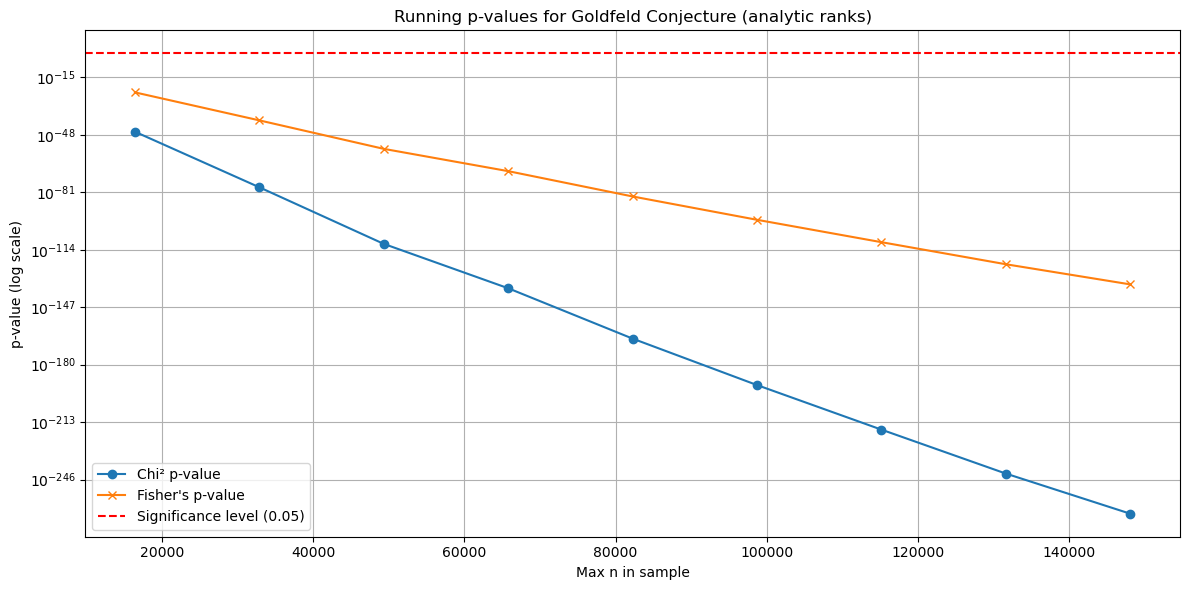

In [15]:
plt.figure(figsize=(12, 6))

plt.plot(results_df['upto_n'], results_df['chi2_pval'], label='Chi² p-value', marker='o')
plt.plot(results_df['upto_n'], results_df['fisher_pval'], label="Fisher's p-value", marker='x')

plt.axhline(0.05, linestyle='--', color='red', label='Significance level (0.05)')
plt.yscale('log')
plt.xlabel("Max n in sample")
plt.ylabel("p-value (log scale)")
plt.title("Running p-values for Goldfeld Conjecture (analytic ranks)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
